In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns; #sns.set()
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, KFold
%matplotlib inline
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
# warnings.filterwarnings('ignore') # disable all warnings
warnings.filterwarnings(action='once') # warn only once
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
data=pd.read_csv("../input/who_suicide_statistics.csv")


data.astype('object').describe()


# Any results you write to the current directory are saved as output.

['who_suicide_statistics.csv']


,country,year,sex,age,suicides_no,population
count,43776,43776,43776,43776,41520.0,38316.0
unique,141,38,2,6,2231.0,32439.0
top,Netherlands,2009,male,35-54 years,0.0,24000.0
freq,456,1452,21888,7296,9299.0,24.0


In [3]:


data.astype('object').describe()



,country,year,sex,age,suicides_no,population
count,43776,43776,43776,43776,41520.0,38316.0
unique,141,38,2,6,2231.0,32439.0
top,Netherlands,2009,male,35-54 years,0.0,24000.0
freq,456,1452,21888,7296,9299.0,24.0


In [4]:
data_clean = data.dropna()
data_clean.head()

,country,year,sex,age,suicides_no,population
24,Albania,1987,female,15-24 years,14.0,289700.0
25,Albania,1987,female,25-34 years,4.0,257200.0
26,Albania,1987,female,35-54 years,6.0,278800.0
27,Albania,1987,female,5-14 years,0.0,311000.0
28,Albania,1987,female,55-74 years,0.0,144600.0


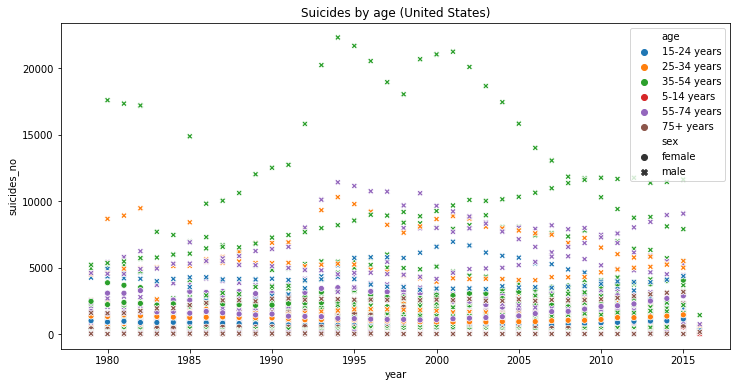

In [5]:
target_country = "United States"
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title( 'Suicides by age ({})'.format(target_country))
p = sns.scatterplot(x="year", y="suicides_no", data=data_clean,hue='age',style='sex')

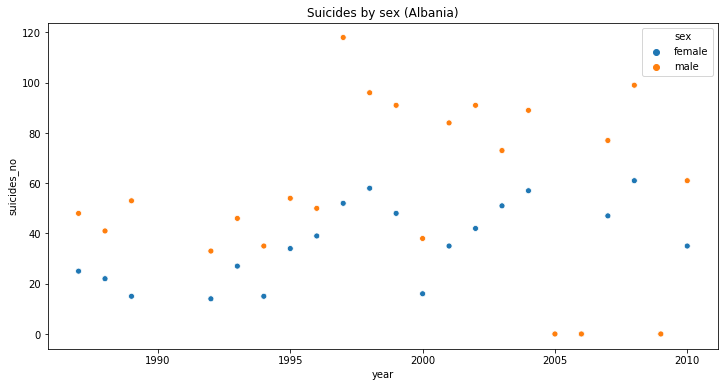

In [6]:
target_country = "Albania"
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title( 'Suicides by sex ({})'.format(target_country))
sui_by_sex = data_clean[data_clean["country"].str.contains(target_country)].groupby(['sex','year'],as_index=False).sum()
p = sns.scatterplot(x="year", y="suicides_no", data=sui_by_sex,hue='sex')

In [7]:
agemap = {}
i = 0
for x in data.age.unique():
    agemap[x] = i
    i+=1

# since there are only two values here, we can do a mapping for gender. If >2 types listed, we could do a one-hot encoding instead.
gendermap = {}
i = 0
for x in data.sex.unique():
    gendermap[x] = i
    i+=1
    
data_clean['age_id'] = data['age'].map(agemap)
data_clean['sex_id'] = data['sex'].map(gendermap)

In [8]:
x = data_clean.drop(['sex','age'], axis = 1)
x = pd.get_dummies(x)
y = x[['suicides_no']]
x = x.drop('suicides_no',axis=1)

/opt/conda/lib/python3.6/site-packages/seaborn/palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


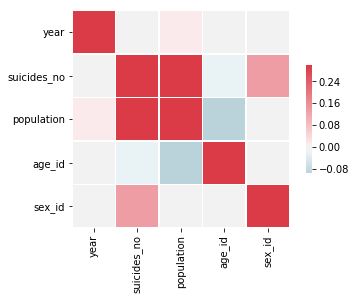

In [9]:
corr = data_clean.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, vmax=.3, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
# Separate the suicides and population values by gender
data_by_gender = data_clean.loc[data_clean['sex_id'] == 1]
data_by_females = data_clean.loc[data_clean['sex_id'] == 0]
#data_by_gender['f_suicides_no'] = data_by_gender.merge(data_by_females, on=['country', 'year', 'age'])[['suicides_no_y']]
data_by_gender.rename(columns={'suicides_no':'m_suicides_no'}, inplace=True)
data_by_gender.rename(columns={'population':'m_population'}, inplace=True)

# Wrangle the data into the right format without redundant columns
data_by_gender = data_by_gender.merge(data_by_females, on=['country', 'year', 'age'])
data_by_gender = data_by_gender.drop(labels=['age','age_id_y','sex_x','sex_y','sex_id_y','sex_id_x'],axis=1)
data_by_gender.rename(columns={'population':'f_population', 'age_id_x': 'age_id'}, inplace=True)
data_by_gender.rename(columns={'suicides_no':'f_suicides_no'}, inplace=True)

In [11]:
data_by_gender

,country,year,m_suicides_no,m_population,age_id,f_suicides_no,f_population
0,Albania,1987,21.0,312900.0,0,14.0,289700.0
1,Albania,1987,9.0,274300.0,1,4.0,257200.0
2,Albania,1987,16.0,308000.0,2,6.0,278800.0
3,Albania,1987,0.0,338200.0,3,0.0,311000.0
4,Albania,1987,1.0,137500.0,4,0.0,144600.0
5,Albania,1987,1.0,21800.0,5,1.0,35600.0
6,Albania,1988,17.0,319200.0,0,8.0,295600.0
7,Albania,1988,5.0,279900.0,1,5.0,262400.0
8,Albania,1988,14.0,314100.0,2,4.0,284500.0
9,Albania,1988,0.0,345000.0,3,0.0,317200.0


In [12]:
x_s = pd.get_dummies(data_by_gender)
y_s = x_s[['f_suicides_no','m_suicides_no']]
x_s = x_s.drop(['f_suicides_no','m_suicides_no'],axis=1)
x_s.head()

,year,m_population,age_id,f_population,country_Albania,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Aruba,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Bermuda,country_Bosnia and Herzegovina,country_Brazil,country_Brunei Darussalam,country_Bulgaria,country_Cabo Verde,country_Canada,country_Cayman Islands,country_Chile,country_Colombia,country_Costa Rica,country_Croatia,country_Cuba,country_Cyprus,country_Czech Republic,country_Denmark,country_Dominica,country_Ecuador,country_Egypt,country_El Salvador,country_Estonia,country_Fiji,...,country_Philippines,country_Poland,country_Portugal,country_Puerto Rico,country_Qatar,country_Republic of Korea,country_Republic of Moldova,country_Reunion,country_Rodrigues,country_Romania,country_Russian Federation,country_Saint Kitts and Nevis,country_Saint Lucia,country_Saint Vincent and Grenadines,country_San Marino,country_Sao Tome and Principe,country_Serbia,country_Seychelles,country_Singapore,country_Slovakia,country_Slovenia,country_South Africa,country_Spain,country_Sri Lanka,country_Suriname,country_Sweden,country_Switzerland,country_TFYR Macedonia,country_Thailand,country_Trinidad and Tobago,country_Turkey,country_Turkmenistan,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States of America,country_Uruguay,country_Uzbekistan,country_Venezuela (Bolivarian Republic of),country_Virgin Islands (USA)
0,1987,312900.0,0,289700.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1987,274300.0,1,257200.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1987,308000.0,2,278800.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1987,338200.0,3,311000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1987,137500.0,4,144600.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


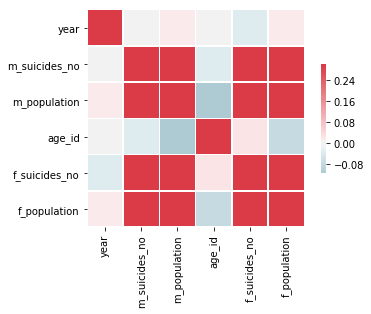

In [13]:
corr_by_gender = data_by_gender.corr()
sns.heatmap(corr_by_gender, vmax=.3, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=314)

# and again by gender
x_s_train, x_s_test, y_s_train, y_s_test = train_test_split(x_s, y_s, test_size=0.25, random_state=314)

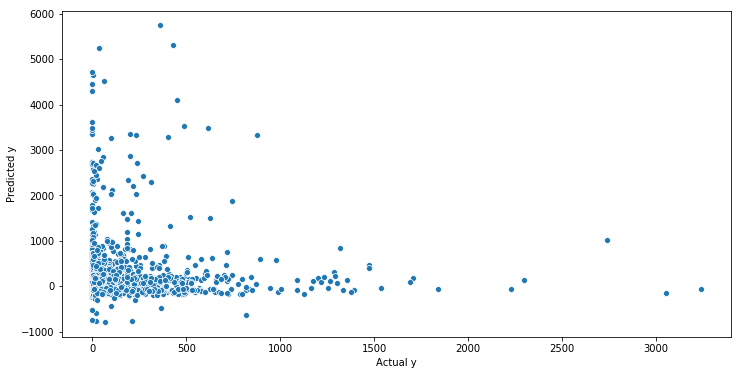

The r-squared value is: 0.5150928212956514, and MSE is: 392464.02433734277


In [15]:
reg = LinearRegression().fit(x_train, y_train)
y_hat = reg.predict(x_test)
y_hat = pd.DataFrame(y_hat,columns=['suicides_no'])

#compute metrics

mse = (metrics.mean_squared_error(y_pred=y_hat, y_true=y_test ))
r2 = metrics.r2_score(y_pred=y_hat, y_true=y_test)
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=y_test['suicides_no'],y=y_hat['suicides_no'])
ax.set(xlabel = 'Actual y', ylabel="Predicted y")
plt.show()
print('The r-squared value is: {}, and MSE is: {}'.format(r2, mse))

In [ ]:
kf = KFold(5,shuffle=True)
reg_cv = LinearRegression()
las_cv = Lasso()
kn_cv = KNeighborsRegressor(n_neighbors=30)
reg_cv_model = cross_validate(reg_cv, X=x, y=y, cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=False)
las_cv_model = cross_validate(las_cv, X=x, y=y, cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=False)
kn_cv_model = cross_validate(kn_cv, X=x, y=y, cv=kf, scoring=('neg_mean_squared_error', 'r2'), return_train_score=False)

reg_cv_scores = cross_val_score(reg_cv, X=x, y=y, cv=kf)
las_cv_scores = cross_val_score(las_cv, X=x, y=y, cv=kf)
kn_cv_scores = cross_val_score(kn_cv, X=x, y=y, cv=kf)
print('Linear Regression: The average r-squared value from {}-fold cross-validation is: {}'.format(kf.n_splits, reg_cv_scores.mean()), ('\nLasso: The average r-squared value from {}-fold cross-validation is: {}'.format(kf.n_splits, las_cv_scores.mean())), ('\nk-NN Regressor: The average r-squared value from {}-fold cross-validation is: {}'.format(kf.n_splits, kn_cv_scores.mean())))

In [ ]:
x_usa = data_clean.drop(['sex','age'], axis = 1)
x_usa = x_usa[x_usa['country'].str.contains("Japan")]
x_usa = x_usa.drop('country',axis=1)
x_usa = pd.get_dummies(x_usa)
y_usa = x_usa[['suicides_no']]
x_usa = x_usa.drop('suicides_no',axis=1);
x_usa_train, x_usa_test, y_usa_train, y_usa_test = train_test_split(x_usa, y_usa, test_size=0.25, random_state=314)

In [ ]:
reg_usa = LinearRegression().fit(x_usa_train, y_usa_train)
y_usa_hat = reg_usa.predict(x_usa_test)
y_usa_hat = pd.DataFrame(y_usa_hat,columns=['suicides_no'])

#compute metrics
mse_usa = (metrics.mean_squared_error(y_pred=y_usa_hat, y_true=y_usa_test ))
r2_usa = metrics.r2_score(y_pred=y_usa_hat, y_true=y_usa_test)

#fig_usa, ax_usa = plt.subplots(figsize=(12,6))

fig, ax = plt.subplots()
ax.scatter(x=y_usa_test['suicides_no'],y=y_usa_hat['suicides_no'])
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()
#ax_usa.set(xlabel = 'Actual y', ylabel="Predicted y")

print('The r-squared value is: {}, and MSE is: {}'.format(r2_usa, mse_usa))